# Homework 10

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sb
import statsmodels.api as sm
import sklearn.tree as tr
import sklearn.ensemble as ens
import sklearn.linear_model as slm
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [2]:
nfl = pd.read_csv("./NFL_play_by_play_2022.csv.gz")
nfl.shape

(50147, 340)

These data record play-by-play information for all games in the 2022 National Football League (NFL) season. These data were downloaded using the `nflverse` package for the R programming language (another statistics and data science environment), lightly edited, and saved in a tabular format for us to use in Python.

There are many measurements for each play, some of which are computed values from `nflverse`. Here's a brief list using the data dictionary.

In [3]:
nfl_data_dictionary = pd.read_csv("./NFL_play_by_play_data_dictonary.csv", index_col = "Field")
nfl_data_dictionary.loc[["play_id", "game_id", "home_team", "away_team", "posteam",
                         "defteam", "yardline_100", "down", "ydstogo",
                        "touchdown", "play_type"]]

,Description,Type
Field,,
play_id,Numeric play id that when used with game_id and drive provides the unique identifier for a single play.,numeric
game_id,Ten digit identifier for NFL game.,character
home_team,String abbreviation for the home team.,character
away_team,String abbreviation for the away team.,character
posteam,String abbreviation for the team with possession.,character
defteam,String abbreviation for the team on defense.,character
yardline_100,Numeric distance in the number of yards from the opponent's endzone for the posteam.,numeric
down,The down for the given play.,numeric
ydstogo,Numeric yards in distance from either the first down marker or the endzone in goal down situations.,numeric


## Question 1

### Part (a)

For this section, we will aggregate the individual plays into games.

Use `groupby` on `"game_id"` to aggregate(`.agg`) the games. Include the following columns:

```
{"home_score": "first",
 "away_score": "first",
 "week": "first",
 "home_team": "first",
 "away_team": "first",
 "roof": "first",
 "wind": "median",
 "temp": "median",
 "play_id": "size"}
```

Call the result `games`. Demonstrate using a plot that shows the number of games played each week. The season is composed of a regular season in which all teams play and post season playoffs in which only some teams play. Using the plot, how many weeks are in a regular season?



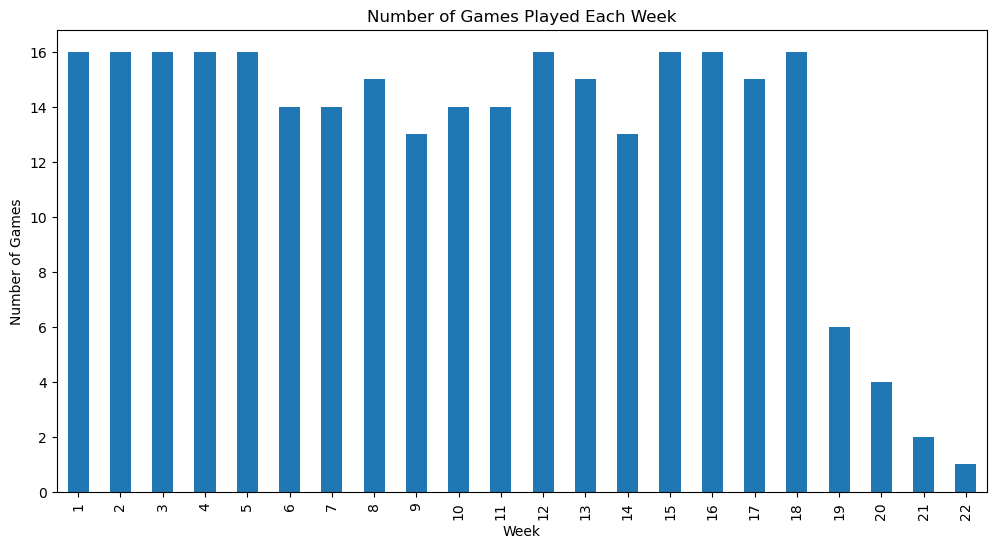

In [4]:
# Aggregate the individual plays into games
games = nfl.groupby("game_id").agg({
    "home_score": "first",
    "away_score": "first",
    "week": "first",
    "home_team": "first",
    "away_team": "first",
    "roof": "first",
    "wind": "median",
    "temp": "median",
    "play_id": "size"
}).reset_index()

# Plot the number of games played each week
games_per_week = games["week"].value_counts().sort_index()
games_per_week.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Week')
plt.ylabel('Number of Games')
plt.title('Number of Games Played Each Week')
plt.show()



### Part (b)

Some people think teams benefit from playing at home. Compute the difference between the home team score and the away team score and store it as a new column (call it `"home_away_score"`).

Plot this new variable. Do you see evidence of this claim?

## Answer: I do not see strong evidence because the distribution is normal and centered around 0, means that the difference between home and away score is not significant. 


In [ ]:
# Compute the difference between home team score and away team score
games['home_away_score'] = games['home_score'] - games['away_score']

# Plot the new variable
plt.figure(figsize=(12, 6))
plt.hist(games['home_away_score'], bins=20, edgecolor='black')
plt.xlabel('Home - Away Score Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Home - Away Score Difference')
plt.show()




### Part (c)

Suppose these games represent a sample from all possible games that could have been played in 2022. Let $X$ be the home and away teams' score difference. Test the hypothesis:

$H_0: E(X) = 0$ against $H_1: E(X) \ne 0$

at the 5% level or create a 95% confidence interval for $E(X)$. What do you conclude about this hypothesis. Interpret it as evidence for or against the claim of home field advantage.



In [7]:
from scipy import stats

# Perform a one-sample t-test
t_stat, p_value = stats.ttest_1samp(games['home_away_score'], 0)

# Calculate the 95% confidence interval
mean_diff = games['home_away_score'].mean()
std_err = stats.sem(games['home_away_score'])
confidence_interval = stats.t.interval(0.95, len(games['home_away_score'])-1, loc=mean_diff, scale=std_err)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print(f"95% confidence interval: {confidence_interval}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence that the mean score difference is not zero.")
else:
    print("Fail to reject the null hypothesis. There is no evidence that the mean score difference is not zero.")

T-statistic: 2.8333005167921805
P-value: 0.00493827905332151
95% confidence interval: (0.6374101074477692, 3.5386462305804)
Reject the null hypothesis. There is evidence that the mean score difference is not zero.



### Part (d)

One theory of home game advantage states that teams that play outdoors in cold weather are acclimated to cold weather, while teams that do not play outdoors will not perform as well in outdoor games.

We will ask a slightly simpler question and ask if the average home and away difference in outdoor games is larger than in indoor games.

To do this, we need to identify if a game is played outdoors. Investigate the `"roof"` column and create a new column (call it `"is_outdoors"`) that has the value True if the games is played outdoors and False otherwise.


Use a box plot to explore whether games played outdoors have different home and away score differences than non-outdoor games.



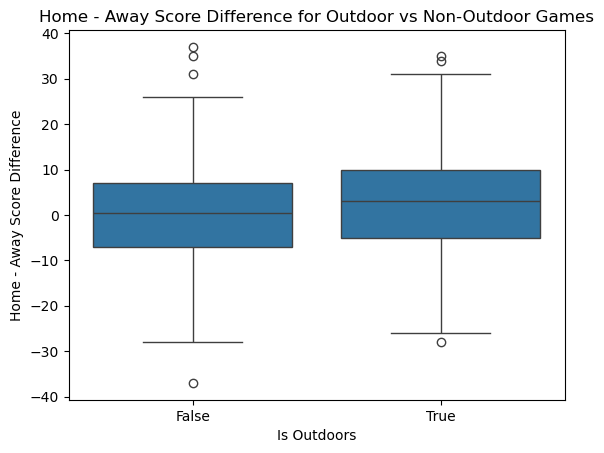

In [9]:
# Create a new column 'is_outdoors' based on the 'roof' column
games['is_outdoors'] = games['roof'].apply(lambda x: x == 'outdoors')

# Use a box plot to explore the differences in home and away score differences

sb.boxplot(x='is_outdoors', y='home_away_score', data=games)
plt.xlabel('Is Outdoors')
plt.ylabel('Home - Away Score Difference')
plt.title('Home - Away Score Difference for Outdoor vs Non-Outdoor Games')
plt.show()

# The average score difference for outdoor games is higher than for non-outdoor games. 


### Part (e)

Perform a difference of means hypothesis test to the the hypothesis that the average score difference is the same for both outdoors and non-outdoors games against the alternative that it is different. At the 5% level (or using a 95% confidence interval) what do you conclude?


In [10]:
# Perform a two-sample t-test
outdoor_scores = games[games['is_outdoors']]['home_away_score']
indoor_scores = games[~games['is_outdoors']]['home_away_score']

t_stat, p_value = stats.ttest_ind(outdoor_scores, indoor_scores, equal_var=False)

# Calculate the 95% confidence interval for the difference in means
mean_diff = outdoor_scores.mean() - indoor_scores.mean()
std_err_diff = np.sqrt(stats.sem(outdoor_scores)**2 + stats.sem(indoor_scores)**2)
confidence_interval = (mean_diff - 1.96 * std_err_diff, mean_diff + 1.96 * std_err_diff)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print(f"95% confidence interval: {confidence_interval}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence that the mean score difference is not the same for outdoor and non-outdoor games.")
else:
    print("Fail to reject the null hypothesis. There is no evidence that the mean score difference is different for outdoor and non-outdoor games.")

T-statistic: 1.5659442016766973
P-value: 0.11909630681367733
95% confidence interval: (-0.6234696316335464, 5.578700128087448)
Fail to reject the null hypothesis. There is no evidence that the mean score difference is different for outdoor and non-outdoor games.





### Part (f)

Another way to perform this test is to use linear regression. If we write:

$$E(Y \mid X = x) = a + b x$$

Then the difference of means for $$E(Y \mid X = 1) - E(Y \mid X = 0) = (a + b ) - (a + b \cdot 0) = b$$

The hypothesis test will use a slightly different standard error calculation, but it will be still be a valid way to test this hypothesis or get confidence intervals.

Use the `sm.OLS` to perform a linear regression of `"home_away_score`" on `"is_outdoors"`. You will need to convert the `"is_outdoors"` variable to a numeric 1/0 version first. This can be done by using `.astype('int')` to create a new column of 0 and 1 values.

Display the confidence intervals for each coefficient. For the `is_outdoors` coefficient, what do you see?

In [11]:
## quick example for conversion
tf = pd.Series([True, False, False, True])
tf.astype("int")

0    1
1    0
2    0
3    1
dtype: int64

In [ ]:
# Convert 'is_outdoors' to numeric 0/1
games['is_outdoors_numeric'] = games['is_outdoors'].astype('int')

# Perform linear regression
X = sm.add_constant(games['is_outdoors_numeric'])
y = games['home_away_score']
model = sm.OLS(y, X).fit()

# Display the confidence intervals for each coefficient
print(model.summary())
print(model.conf_int())

# Interpretation
conf_int_is_outdoors = model.conf_int().loc['is_outdoors_numeric']
print(f"95% confidence interval for 'is_outdoors' coefficient: {conf_int_is_outdoors}")

# is outdoors coefficient is positive : 2.4776, which means that the average score difference is higher for outdoor games compared to non-outdoor games. 
# Every outdoor game is associated with an increase in the average score difference by 2.4776 points.

                            OLS Regression Results                            
Dep. Variable:        home_away_score   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.543
Date:                Wed, 04 Dec 2024   Prob (F-statistic):              0.112
Time:                        20:38:00   Log-Likelihood:                -1116.7
No. Observations:                 284   AIC:                             2237.
Df Residuals:                     282   BIC:                             2245.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.4479    

### Part (g)

If our theory that outdoor games helps the home team because of the weather, perhaps we can use measured temperature and wind to see if decreasing temperature and increasing wind increases the the home team's score over the away team.

You will notice that there is some amount of missingness for the `"temp"` and `"wind"` columns. Create a new column that track if either are missing for each game.

Compute the conditional probability of missing either of these measurements for the different `"roof"` categories. What do you notice?



In [14]:
# Create a new column that tracks if either 'temp' or 'wind' are missing
games['temp_or_wind_missing'] = games[['temp', 'wind']].isnull().any(axis=1)

# Compute the conditional probability of missing either 'temp' or 'wind' for different 'roof' categories
conditional_prob = games.groupby('roof')['temp_or_wind_missing'].mean()

print(conditional_prob)

# Missing possibility is the highest for outdoor games compared to other roof types. In other types, eiterh temp or wind is missing.

roof
closed      1.000000
dome        1.000000
open        1.000000
outdoors    0.430851
Name: temp_or_wind_missing, dtype: float64




### Part (h)

Perform a multiple linear regression using `"is_outdoors"` (converted to 0 and 1), `"wind"`, and `"temp`". Print out the parameters and 95% confidence intervals.

For each factor, holding the others constant, would we reject the hypothesis that the conditional mean of the score difference is independent of the factor?


In [16]:
# Prepare the data for regression
X = games[['is_outdoors_numeric', 'wind', 'temp']].fillna(0)  # Fill missing values with 0
X = sm.add_constant(X)  # Add a constant term
y = games['home_away_score']

# Perform the regression
model = sm.OLS(y, X).fit()

# Print out the parameters and 95% confidence intervals
print(model.summary())
print(model.conf_int())

# Interpretation
conf_int_is_outdoors = model.conf_int().loc['is_outdoors_numeric']
conf_int_wind = model.conf_int().loc['wind']
conf_int_temp = model.conf_int().loc['temp']

print(f"95% confidence interval for 'is_outdoors' coefficient: {conf_int_is_outdoors}")
print(f"95% confidence interval for 'wind' coefficient: {conf_int_wind}")
print(f"95% confidence interval for 'temp' coefficient: {conf_int_temp}")

# Check if we reject the null hypothesis for each factor
if conf_int_is_outdoors[0] > 0 or conf_int_is_outdoors[1] < 0:
    print("Reject the null hypothesis for 'is_outdoors'.")
else:
    print("Fail to reject the null hypothesis for 'is_outdoors'.")

if conf_int_wind[0] > 0 or conf_int_wind[1] < 0:
    print("Reject the null hypothesis for 'wind'.")
else:
    print("Fail to reject the null hypothesis for 'wind'.")

if conf_int_temp[0] > 0 or conf_int_temp[1] < 0:
    print("Reject the null hypothesis for 'temp'.")
else:
    print("Fail to reject the null hypothesis for 'temp'.")

                            OLS Regression Results                            
Dep. Variable:        home_away_score   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.849
Date:                Wed, 04 Dec 2024   Prob (F-statistic):             0.0378
Time:                        20:46:28   Log-Likelihood:                -1113.7
No. Observations:                 284   AIC:                             2235.
Df Residuals:                     280   BIC:                             2250.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.4479    



## Question 2

In this question, we will look at the relationship between different types of plays (passing the ball, running the ball) and the "down" (the 4 attempts the offensive team has to gain 10 yards before turning over the ball to the other side).

Most plays are either passing or running the ball. When teams are on their 4th down and do not think they can make the full 10 years, they will often punt it. Because this almost only happens on 4th downs and several of the other play types are so specialized, we will focus on just runs and passes.

In [17]:
plays = nfl.loc[nfl["play_type"].isin(["run", "pass"])].dropna(subset = ["play_type", "down"])
plays["play_type"].value_counts()

play_type
pass    20299
run     15005
Name: count, dtype: int64

We will relate this to the "down" column to see where runs and passes are more common.

In [18]:
plays["down"].describe()

count    35304.000000
mean         1.810985
std          0.834178
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: down, dtype: float64

### Part (a)

 Calculate the empirical joint probabilities of `play_type` and `down` in the `plays` table. Also compute the counts (we will use both later).

Look at the results. Do you notice anywhere that the patterns in one column are not the same as the patterns in the other column?

Hint: You may find it helpful to use `.value_counts()` with both `normalize=True` and `normalize=False`. Additionally, if there are combinations with no occurrences, `.value_counts()` will report a `NaN`. We can use `.fillna(0)` to replace these `NaN`s with `0`s.



In [20]:
# Calculate the empirical joint probabilities
joint_probabilities = plays.value_counts(subset=['play_type', 'down'], normalize=True).unstack().fillna(0)

# Calculate the counts
counts = plays.value_counts(subset=['play_type', 'down'], normalize=False).unstack().fillna(0)

print("Joint Probabilities:")
print(joint_probabilities)

print("\nCounts:")
print(counts)

# The fourth down pass and run probability is significant lower than the other down pass probabilities.

Joint Probabilities:
down            1.0       2.0       3.0       4.0
play_type                                        
pass       0.210005  0.197966  0.153864  0.013143
run        0.228444  0.135990  0.051892  0.008696

Counts:
down        1.0   2.0   3.0  4.0
play_type                       
pass       7414  6989  5432  464
run        8065  4801  1832  307



### Part (b)

We are ultimately concerned with whether the two variables, `play_type` and `down` are independent. Assuming that they are indeed independent (i.e. under the null hypothesis), calculate their joint probability using the product of the marginals.


Then, multiply these joint probabilities by the number of observations to obtain the expected counts.


In [21]:
# Calculate the marginal probabilities
marginal_play_type = plays['play_type'].value_counts(normalize=True)
marginal_down = plays['down'].value_counts(normalize=True)

# Calculate the joint probabilities under the null hypothesis of independence
expected_joint_probabilities = np.outer(marginal_play_type, marginal_down)

# Convert to DataFrame for better readability
expected_joint_probabilities_df = pd.DataFrame(expected_joint_probabilities, 
                                               index=marginal_play_type.index, 
                                               columns=marginal_down.index)

# Multiply by the total number of observations to get the expected counts
total_observations = plays.shape[0]
expected_counts = expected_joint_probabilities_df * total_observations

print("Expected Joint Probabilities:")
print(expected_joint_probabilities_df)

print("\nExpected Counts:")
print(expected_counts)

Expected Joint Probabilities:
down            1.0       2.0       3.0       4.0
play_type                                        
pass       0.252098  0.192017  0.118305  0.012557
run        0.186351  0.141939  0.087451  0.009282

Expected Counts:
down               1.0          2.0          3.0         4.0
play_type                                                   
pass       8900.074241  6778.982835  4176.635395  443.307529
run        6578.925759  5011.017165  3087.364605  327.692471




### Part (c)

First, calculate and store the `pearson_residuals` by subtracting the expected counts calculated in part (b) from the observed counts calculated in part (a), and dividing by the square root of the expected counts.

Now, perform a Z-test to determine if our two variables `play_type` and `down` are independent, with an $\alpha = 0.003$. Report your findings.


In [22]:
# Calculate the Pearson residuals
pearson_residuals = (counts - expected_counts) / np.sqrt(expected_counts)

# Perform a Z-test
z_scores = pearson_residuals.values.flatten()
z_stat = np.sum(z_scores**2)
p_value = 1 - stats.chi2.cdf(z_stat, df=(counts.shape[0] - 1) * (counts.shape[1] - 1))

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.003
if p_value < alpha:
    print("Reject the null hypothesis. There is evidence that 'play_type' and 'down' are not independent.")
else:
    print("Fail to reject the null hypothesis. There is no evidence that 'play_type' and 'down' are not independent.")

Z-statistic: 1489.167412200256
P-value: 0.0
Reject the null hypothesis. There is evidence that 'play_type' and 'down' are not independent.



### Part (d)

Now, calculate the sum of squares of Pearson residuals.

Then calculate the degrees of freedom for a Chi-squared test, and find the rejection region with $\alpha=0.003$.

Compare the sum of squares of Pearson residuals (our test statistic) to the rejection region. Are the results consistent with the Z-test we performed earlier?



In [24]:
# Calculate the sum of squares of Pearson residuals
sum_of_squares = np.sum(pearson_residuals.values**2)

# Calculate the degrees of freedom for a Chi-squared test
degrees_of_freedom = (counts.shape[0] - 1) * (counts.shape[1] - 1)

# Find the rejection region with alpha=0.003
rejection_region = stats.chi2.ppf(1 - alpha, degrees_of_freedom)

print(f"Sum of squares of Pearson residuals: {sum_of_squares}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print(f"Rejection region (critical value): {rejection_region}")

# Compare the sum of squares of Pearson residuals to the rejection region
if sum_of_squares > rejection_region:
    print("Reject the null hypothesis. The results are consistent with the Z-test.")
else:
    print("Fail to reject the null hypothesis. The results are not consistent with the Z-test.")
    
    

Sum of squares of Pearson residuals: 1489.167412200256
Degrees of freedom: 3
Rejection region (critical value): 13.931422665512084
Reject the null hypothesis. The results are consistent with the Z-test.



## Question 3

In this problem we will use a decision tree to predict the outcome of a play. We will use the `play_type` as the outcome variable and the `down`, `ydstogo`, and `yardline_100` as the predictors.

### Part (a)

Create a new table `plays2` that only includes the columns `play_type`, `down`, `ydstogo`, and `yardline_100`. Drop any rows with missing values. Compute the marginal probabilities for the different play types.

In [25]:
# Create a new table 'plays2' with the specified columns and drop rows with missing values
plays2 = plays[['play_type', 'down', 'ydstogo', 'yardline_100']].dropna()

# Compute the marginal probabilities for the different play types
marginal_probabilities = plays2['play_type'].value_counts(normalize=True)

print("Marginal Probabilities for Play Types:")
print(marginal_probabilities)

Marginal Probabilities for Play Types:
play_type
pass    0.574977
run     0.425023
Name: proportion, dtype: float64


### Part (b)

Using `max_depth = 2, random_state = 101`, use the `DecisionTreeClassifier` from `sklearn.tree` to fit a decision tree to the data. Use the `play_type` as the outcome variable and the `down`, `ydstogo`, and `yardline_100` as the predictors.

Print out the tree using the `plot_tree` function from `sklearn.tree`. By setting the `feature_names = X.columns` and `filled = True`, you can make the tree more readable.


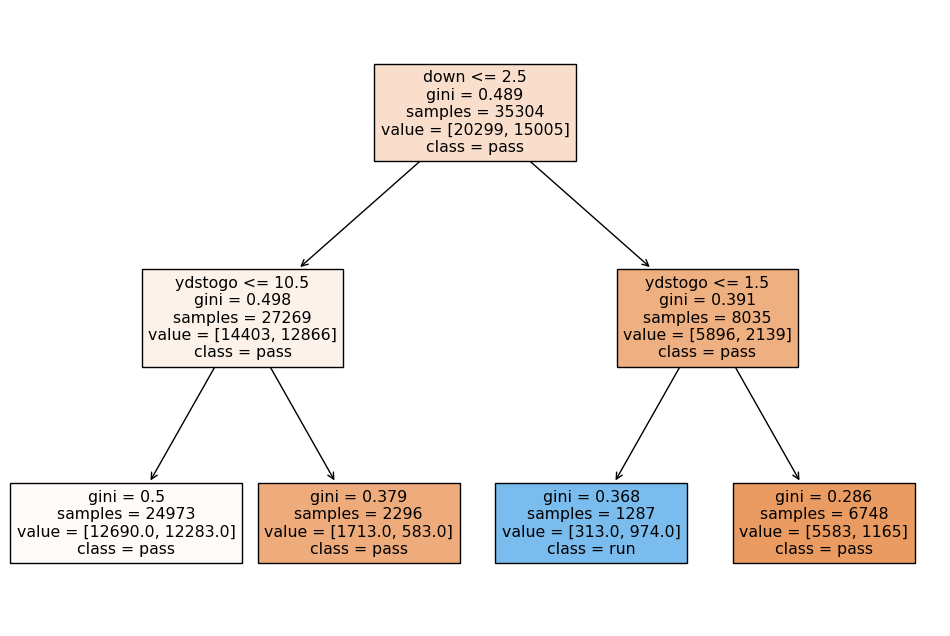

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Define the predictors and outcome variable
X = plays2[['down', 'ydstogo', 'yardline_100']]
y = plays2['play_type']

# Initialize and fit the decision tree classifier
clf = DecisionTreeClassifier(max_depth=2, random_state=101)
clf.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True)
plt.show()



### Part (c)

Inspect the graph in the previous step. The boxes will have numbers like `[100, 200]`. This represents the numbers of passes and runs contained in that split, respectively. Use the graph to answer the following questions:

- What variable was used to create the first split? What is the decision made about that variable?
- For a play that is on 3rd down, with 5 yards to go, and on the 50 yard line, what is the predicted outcome?
- For what group of plays is the decision tree most confident in its prediction?


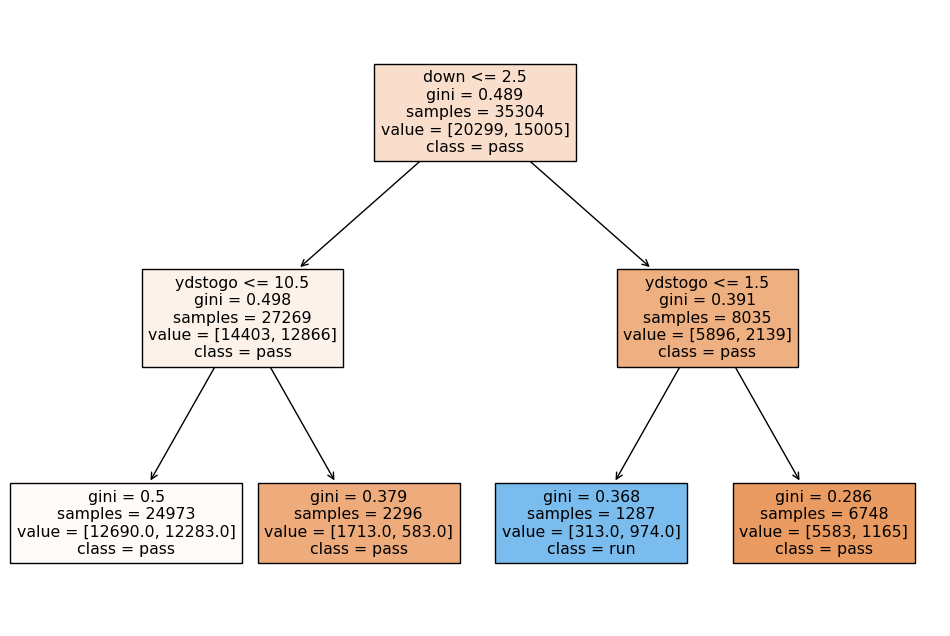

First split variable: down
First split decision: down <= 2.5
Predicted outcome for 3rd down, 5 yards to go, 50 yard line: pass
The tree is most confident in its prediction for plays where down <= 2.5 and ydstogo <= 6.5.


In [32]:
# Plot the decision tree again for reference
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True)
plt.show()

# Answer the questions based on the decision tree graph

# 1. What variable was used to create the first split? What is the decision made about that variable?
first_split_variable = "down"
first_split_decision = "down <= 2.5"

# 2. For a play that is on 3rd down, with 5 yards to go, and on the 50 yard line, what is the predicted outcome?
play_example = pd.DataFrame({"down": [3], "ydstogo": [5], "yardline_100": [50]})
predicted_outcome = clf.predict(play_example)[0]

# 3. For what group of plays is the decision tree most confident in its prediction?
# The tree is most confident in its prediction for plays where down <= 2.5 and ydstogo <= 6.5 (leftmost leaf node).

print(f"First split variable: {first_split_variable}")
print(f"First split decision: {first_split_decision}")
print(f"Predicted outcome for 3rd down, 5 yards to go, 50 yard line: {predicted_outcome}")
print("The tree is most confident in its prediction for plays where down <= 2.5 and ydstogo <= 6.5.")



### Part (d)

Now create a tree without a maximum depth. Using the `predict` method, predict the following plays:

In [ ]:
plays_to_predict = pd.DataFrame({"down": [1, 2, 3, 4],
                                 "ydstogo": [10, 5, 2, 1],
                                 "yardline_100": [20, 50, 80, 99]})

Use the `predict_proba` method to get the probabilities of each play type for each of these plays. For which of these predictions was the tree most confident? For which was the tree the least confident?


In [28]:
# Initialize and fit the decision tree classifier without a maximum depth
clf_full = DecisionTreeClassifier(random_state=101)
clf_full.fit(X, y)

# Define the plays to predict
plays_to_predict = pd.DataFrame({
    "down": [1, 2, 3, 4],
    "ydstogo": [10, 5, 2, 1],
    "yardline_100": [20, 50, 80, 99]
})

# Predict the play types
predictions = clf_full.predict(plays_to_predict)

# Get the probabilities of each play type
probabilities = clf_full.predict_proba(plays_to_predict)

# Print the predictions and probabilities
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Play {i+1}:")
    print(f"  Predicted play type: {pred}")
    print(f"  Probabilities: {prob}")
    print()

# Determine the most and least confident predictions
confidence_scores = probabilities.max(axis=1)
most_confident_index = confidence_scores.argmax()
least_confident_index = confidence_scores.argmin()

print(f"The tree was most confident in its prediction for play {most_confident_index + 1}.")
print(f"The tree was least confident in its prediction for play {least_confident_index + 1}.")

Play 1:
  Predicted play type: run
  Probabilities: [0.36440678 0.63559322]

Play 2:
  Predicted play type: run
  Probabilities: [0.4 0.6]

Play 3:
  Predicted play type: pass
  Probabilities: [0.57142857 0.42857143]

Play 4:
  Predicted play type: run
  Probabilities: [0. 1.]

The tree was most confident in its prediction for play 4.
The tree was least confident in its prediction for play 3.




### Part (e)

Now, use the `cross_val_score` function from `sklearn.model_selection` to perform a 5-fold cross validation on the data. Use the `DecisionTreeClassifier` with `random_state = 100` and `max_depth = 2`. Print out the mean accuracy of the model. (Larger values are better.)

Repeat this process with a `max_depth = 5`. What do you notice about the accuracy of the model as the depth increases?


In [29]:
from sklearn.model_selection import cross_val_score

# Initialize the decision tree classifier with max_depth=2
clf_depth_2 = DecisionTreeClassifier(max_depth=2, random_state=100)

# Perform 5-fold cross-validation and calculate the mean accuracy
scores_depth_2 = cross_val_score(clf_depth_2, X, y, cv=5)
mean_accuracy_depth_2 = scores_depth_2.mean()
print(f"Mean accuracy with max_depth=2: {mean_accuracy_depth_2}")

# Initialize the decision tree classifier with max_depth=5
clf_depth_5 = DecisionTreeClassifier(max_depth=5, random_state=100)

# Perform 5-fold cross-validation and calculate the mean accuracy
scores_depth_5 = cross_val_score(clf_depth_5, X, y, cv=5)
mean_accuracy_depth_5 = scores_depth_5.mean()
print(f"Mean accuracy with max_depth=5: {mean_accuracy_depth_5}")

# Interpretation
if mean_accuracy_depth_5 > mean_accuracy_depth_2:
    print("The accuracy of the model increases as the depth increases.")
else:
    print("The accuracy of the model does not increase as the depth increases.")

Mean accuracy with max_depth=2: 0.5977792631030361
Mean accuracy with max_depth=5: 0.6333845569948322
The accuracy of the model increases as the depth increases.




### Part (f)

Using the `RandomForestClassifier` from `sklearn.ensemble`, fit a random forest model to the data with `n_estimators = 100` and `random_state = 100`. Perform a 5-fold cross validation on the data and print out the mean accuracy of the model. Which technique performs better: decision tree classifiers or random forests?


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialize the random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=100)

# Perform 5-fold cross-validation and calculate the mean accuracy
rf_scores = cross_val_score(rf_clf, X, y, cv=5)
mean_rf_accuracy = rf_scores.mean()
print(f"Mean accuracy of Random Forest: {mean_rf_accuracy}")

# Compare with decision tree classifiers
print(f"Mean accuracy with max_depth=2: {mean_accuracy_depth_2}")
print(f"Mean accuracy with max_depth=5: {mean_accuracy_depth_5}")

if mean_rf_accuracy > max(mean_accuracy_depth_2, mean_accuracy_depth_5):
    print("Random Forest performs better than Decision Tree classifiers.")
else:
    print("Decision Tree classifiers perform better than Random Forest.")

Mean accuracy of Random Forest: 0.6156529281658457
Mean accuracy with max_depth=2: 0.5977792631030361
Mean accuracy with max_depth=5: 0.6333845569948322
Decision Tree classifiers perform better than Random Forest.
